# Industrial Audio - Classification Model
#### Illustrated with a LAX Airplane Landing - Binary Classifier 
Last Updated July 23, 2019

In [1]:
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
import seaborn as sns
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU

from keras import backend as K
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math

Using TensorFlow backend.


Embardier


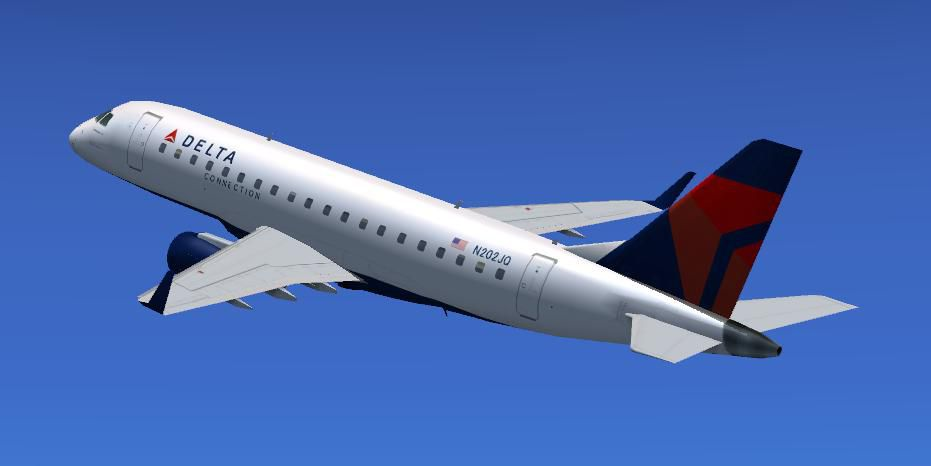

In [40]:
os.chdir("D:\\Airplane-Landing")
import IPython
from IPython.display import Image, Audio
print("Embardier")
Image(filename='embardier.png',width=300, height=200)

In [41]:
fs, audio_sample = wavfile.read("2019_07_21_17_02_29-E75L-skw5610-sba.wav")
IPython.display.Audio(audio_sample, rate=32000)

Embardier


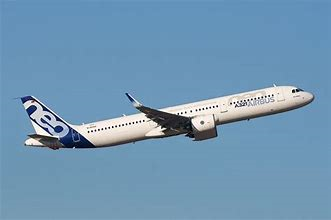

In [5]:
print("Airbus")
Image(filename='airbus.png',width=300, height=200)

### Load and Inspect Data

In [7]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.

print(os.getcwd())

new_total_specificaircraft_1sec_train = np.loadtxt('new_total_specificaircraft_1sec_train.txt', delimiter=',')
new_total_specificaircraft_1sec_test = np.loadtxt('new_total_specificaircraft_1sec_test.txt', delimiter=',')
new_total_notspecificaircraft_1sec_train = np.loadtxt('new_total_notspecificaircraft_1sec_train.txt', delimiter=',')
new_total_notspecificaircraft_1sec_test = np.loadtxt('new_total_notspecificaircraft_1sec_test.txt', delimiter=',')



D:\Airplane-Landing


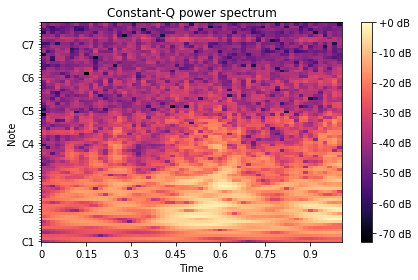

In [8]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(new_total_specificaircraft_1sec_train[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

### Add Labels

In [9]:
# new_total_specificaircraft_1sec_train = np.loadtxt('new_total_specificaircraft_1sec_train.txt', delimiter=',')
# new_total_specificaircraft_1sec_test = np.loadtxt('new_total_specificaircraft_1sec_test.txt', delimiter=',')
# new_total_notspecificaircraft_1sec_train = np.loadtxt('new_total_notspecificaircraft_1sec_train.txt', delimiter=',')
# new_total_notspecificaircraft_1sec_test = np.loadtxt('new_total_notspecificaircraft_1sec_test.txt', delimiter=',')



In [10]:
new_total_specificaircraft_1sec_train = np.c_[ np.ones(len(new_total_specificaircraft_1sec_train)),new_total_specificaircraft_1sec_train] 
new_total_specificaircraft_1sec_train[:, 0] =  1
print(new_total_specificaircraft_1sec_train.shape)

new_total_notspecificaircraft_1sec_train = np.c_[ np.ones(len(new_total_notspecificaircraft_1sec_train)),new_total_notspecificaircraft_1sec_train] 
new_total_notspecificaircraft_1sec_train[:, 0] =  0
print(new_total_notspecificaircraft_1sec_train.shape)

new_total_specificaircraft_1sec_test = np.c_[ np.ones(len(new_total_specificaircraft_1sec_test)),new_total_specificaircraft_1sec_test] 
new_total_specificaircraft_1sec_test[:, 0] = 1
print(new_total_specificaircraft_1sec_test.shape)

new_total_notspecificaircraft_1sec_test = np.c_[ np.ones(len(new_total_notspecificaircraft_1sec_test)),new_total_notspecificaircraft_1sec_test] 
new_total_notspecificaircraft_1sec_test[:, 0] =  0
print(new_total_notspecificaircraft_1sec_test.shape)

(25, 32001)
(47, 32001)
(27, 32001)
(38, 32001)


### Split and Shuffle

In [11]:
all_train_data = np.append(new_total_specificaircraft_1sec_train, new_total_notspecificaircraft_1sec_train, axis=0)
all_test_data = np.append(new_total_specificaircraft_1sec_test, new_total_notspecificaircraft_1sec_test, axis=0)

np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

y_train = np.asarray(all_train_data[:,0])
X_train = np.asarray(all_train_data[:,1:32001])

y_test = np.asarray(all_test_data[:,0])
X_test = np.asarray(all_test_data[:,1:32001])

In [12]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(72,)
(72, 32000)
(65,)
(65, 32000)


#### Preprocessing Data For Model

In [13]:
mfcc_data = []

In [14]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [15]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [16]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [17]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def generate_features(data):
    allfreqs = []
    index = 0
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # stft_data = librosa.core.stft(convert_audio_i2f(raw_data))
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        constant_q_shape_1 = constant_q.shape[1]
        constant_q_shape_0 = constant_q.shape[0]
        primary_input.append(constant_q)
        
    primary_input = np.array(primary_input).reshape(-1, constant_q_shape_0, constant_q_shape_1, 1)
    print(primary_input.shape)

    for rows in range(0,row_count):
        freq = fundamental_freq_gen(data[rows,:])
        index = index + 1
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, 11)
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [18]:
# Generate Training Features
train_cq_input, train_crepe_input = generate_features(X_train)

#Check shape
print(train_cq_input.shape)
print(train_crepe_input.shape)

72
(72, 70, 63, 1)


C:\Anaconda\envs\amlrealtimeai\lib\site-packages\crepe\core.py:208: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]


(72, 1, 11)
72
(72, 11)
(72, 70, 63, 1)
(72, 11)


In [19]:
#Define Single input shape
cq_input_shape = train_cq_input[0].shape
print(cq_input_shape)

crepe_input_shape = train_crepe_input[0].shape
print(crepe_input_shape)

(70, 63, 1)
(11,)


In [20]:
# Generate test features
test_cq_input, crepe_test_input = generate_features(X_test)

65
(65, 70, 63, 1)
(65, 1, 11)
65
(65, 11)


In [21]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [22]:
# Save local files
np.savetxt('y_test_final.txt', y_test, delimiter=',')
np.savetxt('y_train_final.txt', y_train, delimiter=',')

In [23]:
#Check input sizes
print(train_cq_input.shape)
print(test_cq_input.shape)

print(crepe_input_shape)

print(train_crepe_input.shape)
print(crepe_test_input.shape)





(72, 70, 63, 1)
(65, 70, 63, 1)
(11,)
(72, 11)
(65, 11)


### Model Building

#### Model Architecture

In [24]:
def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)
    
    inp = Input(shape=cq_input_shape)
    img_1 = Conv2D(32, kernel_size=(3,3), activation='relu',         
                   kernel_initializer=initializer4,             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(inp)
    img_1 = Dropout(0.05)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.05)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(14)(img_1)
    
#     #input layer
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = Dense(32, activation='relu', kernel_initializer=initializer4,
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_inp)
    crepe_dense = Dropout(0.05)(crepe_dense)   
    concat_layer = keras.layers.concatenate([img_1, crepe_dense])
    concat_dense = Dense(16, activation='relu', kernel_initializer=initializer4,
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_layer)
    concat_dense = Dropout(0.2)(concat_dense)
    concat_dense = Dense(12)(concat_dense)
    
#     #output layer
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, crepe_inp], outputs=[output_layer])
    opt = optimizers.Adam(lr=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-4, decay=0.0, amsgrad=True)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [25]:
# If wanted, add class weighting
# total_len = len(y_train)
# class_weight = {0: total_len/len([x for x in y_train==1 if x]),
#                1: total_len/len([x for x in y_train==2 if x])}

In [26]:
cq_crepe_model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 68, 61, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 68, 61, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 34, 30, 32)   0           dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [27]:
mcp_save = ModelCheckpoint('best_airplane_landing_7_23.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [28]:
print(train_cq_input.shape)
print(test_cq_input.shape)

print(crepe_input_shape)

print(train_crepe_input.shape)
print(crepe_test_input.shape)


(72, 70, 63, 1)
(65, 70, 63, 1)
(11,)
(72, 11)
(65, 11)


In [29]:
history = cq_crepe_model.fit([train_cq_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=3000, verbose=1, batch_size=15,
                         validation_data=([test_cq_input, crepe_test_input], to_categorical(y_test)), 
                         callbacks=[mcp_save], 
                         class_weight=None, 
                         sample_weight=None)

Train on 72 samples, validate on 65 samples
Epoch 1/3000
72/72 [==============================] - 2s 24ms/step - loss: 6.3336 - acc: 0.4236 - val_loss: 4.4656 - val_acc: 0.5538
Epoch 2/3000
72/72 [==============================] - 0s 7ms/step - loss: 6.0472 - acc: 0.5000 - val_loss: 4.4336 - val_acc: 0.5615
Epoch 3/3000
72/72 [==============================] - 0s 6ms/step - loss: 6.6942 - acc: 0.4514 - val_loss: 4.4151 - val_acc: 0.5615
Epoch 4/3000
72/72 [==============================] - 1s 7ms/step - loss: 5.9608 - acc: 0.5000 - val_loss: 4.3942 - val_acc: 0.5615
Epoch 5/3000
72/72 [==============================] - 1s 8ms/step - loss: 6.3358 - acc: 0.4583 - val_loss: 4.3632 - val_acc: 0.5692
Epoch 6/3000
72/72 [==============================] - 1s 7ms/step - loss: 5.5713 - acc: 0.4792 - val_loss: 4.3247 - val_acc: 0.5769
Epoch 7/3000
72/72 [==============================] - 1s 7ms/step - loss: 5.1800 - acc: 0.4861 - val_loss: 4.2894 - val_acc: 0.5846
Epoch 8/3000
72/72 [===========

In [30]:
# stft_model.load_weights('best_stft_model_dropout_checkpoint.hdf5')

In [34]:
# Save Model
cq_crepe_model.save('_BEST_CQ_MODEL_DROPOUT.h5')

#### Graph the results

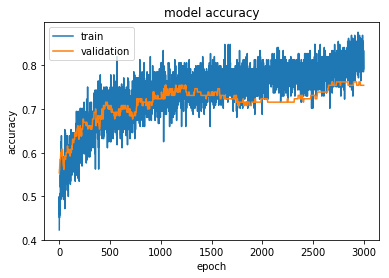

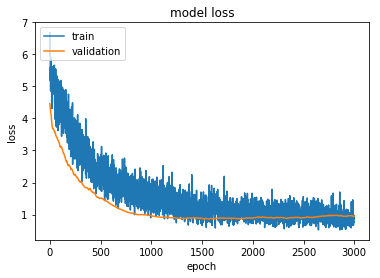

In [35]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
cq_crepe_model.evaluate([test_cq_input, crepe_test_input],y_test_labels)

65/65 [==============================] - 0s 616us/step


[0.9490501403808593, 0.7538461538461538]

#### Confusion Matrix

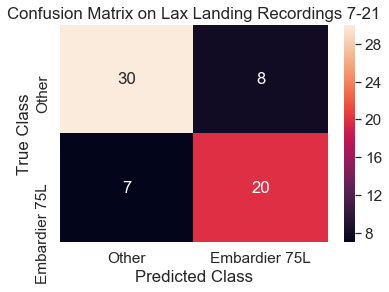

             precision    recall  f1-score   support

        0.0       0.81      0.79      0.80        38
        1.0       0.71      0.74      0.73        27

avg / total       0.77      0.77      0.77        65



In [38]:
preds =np.argmax(cq_crepe_model.predict([test_cq_input, crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

sns.set(font_scale=1.4)

ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix on Lax Landing Recordings 7-21')
ax.xaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.yaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [88]:
cm

array([[29,  9],
       [15, 12]], dtype=int64)